#Import Libraries

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

#Install the Kaggle API

In [2]:
!pip install kaggle


#Upload the kaggle.json file

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"moeedabbasi","key":"eaff3badf706da18e85358398e34740e"}'}

#Setup Kaggle API Credentials

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Download the Kvasir Dataset

In [5]:
!kaggle datasets download -d abdallahwagih/kvasir-dataset-for-classification-and-segmentation

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation
License(s): CC0-1.0
 98% 1.17G/1.20G [00:15<00:00, 98.7MB/s]
100% 1.20G/1.20G [00:16<00:00, 80.3MB/s]


#Unzipping the dataset

In [6]:
!unzip kvasir-dataset-for-classification-and-segmentation.zip -d ./kvasir_data

Streaming output truncated to the last 5000 lines.
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/00687a70-bbad-4bf9-864f-9f7b3c27a2c8.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/0134d93d-0922-4063-9acd-a4177f2b0c07.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/01a57b1a-780f-4e52-9f94-291c2982154d.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/01f092a2-fccb-49f6-af06-8351c8bb47f1.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/022b40a7-a36f-4510-95a1-b6bb709e94ed.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/02b1d319-dea6-418b-969a-c588585cb4f2.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/02de4b4c-8704-45f7-b90f-6004d76bdded.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-dataset/esophagitis/0339a2f7-65bb-41fb-8650-e119670b4e2e.jpg  
  inflating: ./kvasir_data/kvasir-dataset/kvasir-data

#List the Contents

In [7]:
import os
dataset_dir = './kvasir_data'
print(os.listdir(dataset_dir))

['kvasir-dataset', 'kvasir-seg']


#Set the Paths to Images and Masks

In [8]:
image_dir = './kvasir_data/kvasir-seg/Kvasir-SEG/images'
mask_dir = './kvasir_data/kvasir-seg/Kvasir-SEG/masks'

# Load images and masks into arrays

In [9]:
def load_data(image_dir, mask_dir, img_size=(256, 256)):
    images = sorted([os.path.join(image_dir, img) for img in os.listdir(image_dir)])
    masks = sorted([os.path.join(mask_dir, msk) for msk in os.listdir(mask_dir)])

    X = []
    Y = []
    for img_path, mask_path in zip(images, masks):
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize image to range [0, 1]

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = np.expand_dims(mask, axis=-1)
        mask = mask / 255.0  # Normalize mask to range [0, 1]

        X.append(img)
        Y.append(mask)

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

X, Y = load_data(image_dir, mask_dir)

# Split into training and validation sets

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

Training samples: 800, Validation samples: 200


# UNet Model

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


#loss function,optimizer and summary

In [12]:
model = unet_model(input_size=(256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 1024)   │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1536)   │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

#Model Training

In [13]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=15, batch_size=16)

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.8348 - loss: 19.6780 - val_accuracy: 0.8336 - val_loss: 0.3895
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 868ms/step - accuracy: 0.8423 - loss: 0.3665 - val_accuracy: 0.8336 - val_loss: 0.3858
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 863ms/step - accuracy: 0.8475 - loss: 0.3563 - val_accuracy: 0.8336 - val_loss: 0.3676
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 862ms/step - accuracy: 0.8428 - loss: 0.3509 - val_accuracy: 0.8336 - val_loss: 0.3668
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 854ms/step - accuracy: 0.8447 - loss: 0.3431 - val_accuracy: 0.8336 - val_loss: 0.3671
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 905ms/step - accuracy: 0.8399 - loss: 0.3531 - val_accuracy: 0.8336 - val_loss: 0.3803
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 827ms/step - accuracy: 0.8406 - loss: 0.3518 - val_accuracy: 0.8336 - val_loss: 0.3632
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 860ms/step - accuracy: 0.8458 - loss: 0.3473 - val_accur

# Model Evaluation

In [14]:
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 374ms/step - accuracy: 0.8426 - loss: 0.3506
Validation Loss: 0.3399030566215515, Validation Accuracy: 0.8474978804588318


#Visualize Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


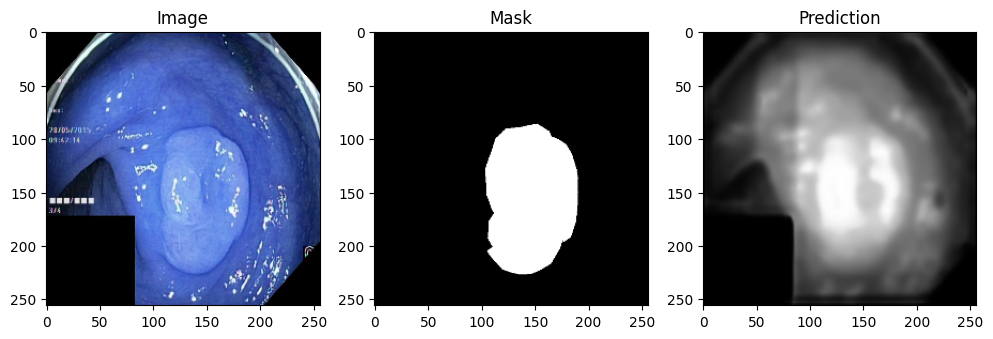

In [15]:
import matplotlib.pyplot as plt

def plot_sample(image, mask, prediction):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title('Mask')
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(prediction, cmap='gray')
    plt.show()

sample_image = X_val[0]
sample_mask = Y_val[0]
prediction = model.predict(np.expand_dims(sample_image, axis=0))[0]
plot_sample(sample_image, sample_mask, prediction)


In [23]:
import torch
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path in Google Drive where the model will be saved
save_path = '/content/drive/My Drive/MyModel/unet_model.h5'

model.save(save_path)
print(f"Model saved to {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/My Drive/MyModel/unet_model.h5
